## 꽃 이미지 분류 (데이지 vs 민들레)

이 노트북은 데이지(daisy)와 민들레(dandelion) 이미지를 분류하는 딥러닝 모델을 구축하는 과정을 다룹니다. 전체 과정은 다음과 같습니다:

1.  **데이터 준비**: 폴더에 저장된 이미지 파일들을 읽어 NumPy 배열로 변환하고, 효율적인 로딩을 위해 `.npz` 파일로 저장합니다.
2.  **데이터 로딩**: 저장된 NumPy 파일을 불러와 훈련 및 테스트 데이터셋을 구성합니다.
3.  **데이터 전처리**: 완전 연결 신경망(DNN)에 맞게 데이터를 2차원으로 변환하고 스케일링합니다.
4.  **모델 구축**: Keras `Sequential` API를 사용하여 분류 모델을 정의합니다.
5.  **모델 훈련**: 준비된 데이터로 모델을 학습시킵니다.
6.  **모델 평가**: 학습된 모델의 성능을 테스트 데이터셋으로 평가하고 결과를 시각화합니다.

### 1. 라이브러리 임포트 및 기본 설정

In [9]:
import numpy as np
import os
import PIL.Image as pilimg
import imghdr
import tensorflow as tf
from keras import models, layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob

# 기본 경로 설정
base_path = "../../data/flowers2"

### 2. 데이터 준비: 이미지 파일을 NumPy 배열로 변환

원본 이미지 파일들을 직접 다루는 것은 비효율적이므로, 모든 이미지를 일정한 크기(80x80)로 조정하고 NumPy 배열로 변환하여 `.npz` 파일로 저장합니다. 이 과정은 한 번만 실행하면 되며, 이후에는 저장된 파일을 빠르게 불러올 수 있습니다.

In [10]:
def make_data_from_images(flower_name, label, is_train=True):
    """특정 꽃 이미지를 읽어 npz 파일로 저장합니다."""
    path_type = "train" if is_train else "test"
    path = os.path.join(base_path, path_type, flower_name)
    data = []
    labels = []
    
    print(f"'{flower_name}' ({path_type}) 카테고리 처리 시작...")
    if not os.path.exists(path):
        print(f"  경로를 찾을 수 없습니다: {path}")
        return
        
    filenames = os.listdir(path)
    for i, filename in enumerate(filenames):
        if (i + 1) % 100 == 0:
            print(f"  {i + 1} / {len(filenames)} 번째 파일 처리 중...")
        
        file_path = os.path.join(path, filename)
        try:
            if imghdr.what(file_path) in ["gif", "png", "jpeg", "jpg"]:
                img = pilimg.open(file_path)
                resize_img = img.resize((80, 80))
                pixel = np.array(resize_img)
                if pixel.shape == (80, 80, 3):
                    data.append(pixel)
                    labels.append(label)
        except Exception as e:
            print(f"  파일 처리 오류: {filename}, 오류: {e}")

    save_filename = f"imagedata_{label}_{path_type}.npz"
    np.savez(save_filename, data=data, targets=labels)
    print(f"'{flower_name}' ({path_type}) 데이터 저장 완료 -> {save_filename}")

def initialize_dataset():
    """모든 카테고리에 대해 데이터 생성을 수행합니다."""
    # 이미 필요한 npz 파일 4개가 모두 있는지 확인
    if len(glob.glob('imagedata_*.npz')) >= 4:
        print("이미 전처리된 .npz 파일들이 존재합니다. 데이터 생성을 건너뜁니다.")
        return

    flowers = ["daisy", "dandelion"]
    for i, f in enumerate(flowers):
        make_data_from_images(f, i, is_train=True)
        make_data_from_images(f, i, is_train=False)
    print("\n모든 데이터 저장 완료.")

# 데이터 준비 함수 실행
initialize_dataset()

'daisy' (train) 카테고리 처리 시작...
  100 / 529 번째 파일 처리 중...
  200 / 529 번째 파일 처리 중...
  300 / 529 번째 파일 처리 중...
  400 / 529 번째 파일 처리 중...
  500 / 529 번째 파일 처리 중...
'daisy' (train) 데이터 저장 완료 -> imagedata_0_train.npz
'daisy' (test) 카테고리 처리 시작...
'daisy' (test) 데이터 저장 완료 -> imagedata_0_test.npz
'dandelion' (train) 카테고리 처리 시작...
  100 / 746 번째 파일 처리 중...
  200 / 746 번째 파일 처리 중...
  300 / 746 번째 파일 처리 중...
  400 / 746 번째 파일 처리 중...
  500 / 746 번째 파일 처리 중...
  600 / 746 번째 파일 처리 중...
  700 / 746 번째 파일 처리 중...
'dandelion' (train) 데이터 저장 완료 -> imagedata_1_train.npz
'dandelion' (test) 카테고리 처리 시작...
  100 / 105 번째 파일 처리 중...
'dandelion' (test) 데이터 저장 완료 -> imagedata_1_test.npz

모든 데이터 저장 완료.


### 3. 데이터 로딩 및 전처리
앞서 생성한 `.npz` 파일들을 모두 불러와 하나의 데이터셋으로 합친 후, DNN 모델에 맞게 전처리합니다.

1.  **데이터 로딩**: 훈련용, 테스트용 `.npz` 파일들을 각각 불러와 합칩니다.
2.  **차원 변환**: 3차원 이미지 데이터를 1차원 벡터로 펼칩니다.
3.  **스케일링**: `StandardScaler`를 사용하여 특성 값을 표준화합니다.

In [11]:
def load_and_preprocess_data():
    """npz 파일들을 로드하고 전처리하여 최종 데이터셋을 반환합니다."""
    # 훈련 데이터 로드
    with np.load("imagedata_0_train.npz") as f1, np.load("imagedata_1_train.npz") as f2:
        X_train = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_train = np.concatenate((f1["targets"], f2["targets"]), axis=0)

    # 테스트 데이터 로드
    with np.load("imagedata_0_test.npz") as f1, np.load("imagedata_1_test.npz") as f2:
        X_test = np.concatenate((f1["data"], f2["data"]), axis=0)
        y_test = np.concatenate((f1["targets"], f2["targets"]), axis=0)
        
    # 차원 변환 (Reshape)
    X_train_flat = X_train.reshape(X_train.shape[0], 80 * 80 * 3)
    X_test_flat = X_test.reshape(X_test.shape[0], 80 * 80 * 3)
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_test_scaled = scaler.transform(X_test_flat)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

X_train, y_train, X_test, y_test = load_and_preprocess_data()

print("--- 최종 데이터 형태 ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

--- 최종 데이터 형태 ---
X_train shape: (1275, 19200)
y_train shape: (1275,)
X_test shape: (182, 19200)
y_test shape: (182,)


### 4. 모델 구축
분류를 위한 간단한 DNN 모델을 정의합니다. 마지막 출력층은 2개의 클래스(데이지, 민들레)에 대한 확률을 출력하기 위해 `softmax` 활성화 함수를 사용합니다.

In [12]:
def create_model():
    network = models.Sequential([
        layers.Input(shape=(80 * 80 * 3,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(2, activation="softmax")
    ])

    network.compile(optimizer='rmsprop',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    return network

model = create_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2457728   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2472290 (9.43 MB)
Trainable params: 2472290 (9.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 5. 모델 훈련
전처리된 데이터를 사용하여 모델을 학습시킵니다. `validation_data`를 지정하여 각 에포크마다 테스트 세트에 대한 성능을 함께 확인합니다.

In [13]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test, y_test))

Epoch 1/100


13/13 [==============================] - 1s 41ms/step - loss: 2.7978 - accuracy: 0.5200 - val_loss: 1.6373 - val_accuracy: 0.5769
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 0.8837 - accuracy: 0.6635 - val_loss: 0.9810 - val_accuracy: 0.5495
Epoch 3/100
13/13 [==============================] - 0s 28ms/step - loss: 0.5708 - accuracy: 0.7184 - val_loss: 0.9732 - val_accuracy: 0.5824
Epoch 4/100
13/13 [==============================] - 0s 29ms/step - loss: 0.5571 - accuracy: 0.7435 - val_loss: 0.8006 - val_accuracy: 0.5989
Epoch 5/100
13/13 [==============================] - 0s 27ms/step - loss: 0.7655 - accuracy: 0.7255 - val_loss: 0.8785 - val_accuracy: 0.5769
Epoch 6/100
13/13 [==============================] - 0s 26ms/step - loss: 0.4356 - accuracy: 0.8008 - val_loss: 0.9358 - val_accuracy: 0.5934
Epoch 7/100
13/13 [==============================] - 0s 26ms/step - loss: 0.4983 - accuracy: 0.7984 - val_loss: 0.9798 - val_accuracy: 0.5604
Epoc

### 6. 모델 평가 및 결과 시각화
훈련된 모델의 최종 성능을 평가하고, 훈련 과정 동안의 손실과 정확도 변화를 그래프로 시각화하여 과대적합 여부 등을 확인합니다.


--- 최종 모델 평가 ---
훈련셋   => 손실값: 0.0000, 정확도: 1.0000
테스트셋 => 손실값: 4.4025, 정확도: 0.6538


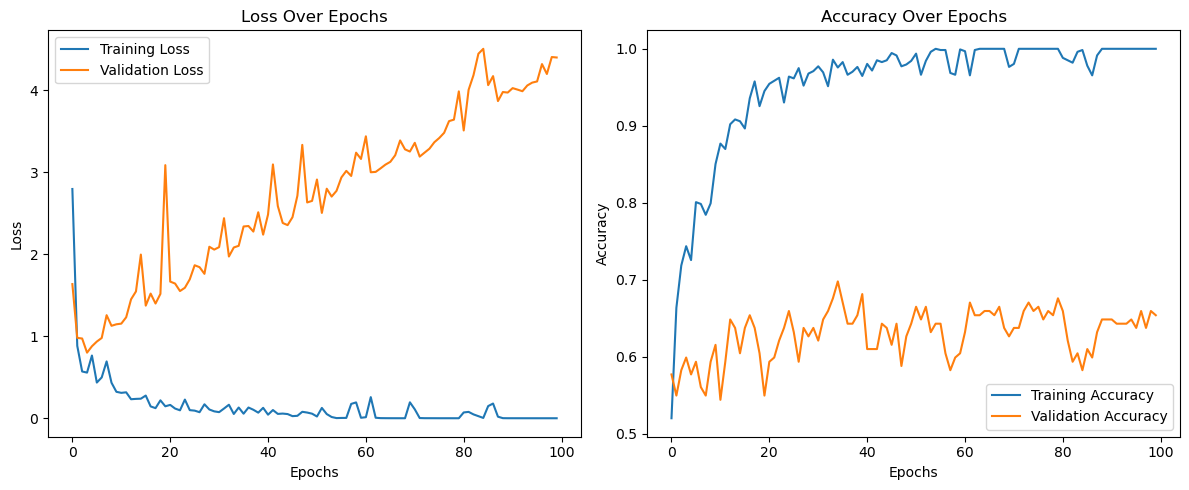

In [14]:
print("\n--- 최종 모델 평가 ---")
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"훈련셋   => 손실값: {train_loss:.4f}, 정확도: {train_acc:.4f}")
print(f"테스트셋 => 손실값: {test_loss:.4f}, 정확도: {test_acc:.4f}")

# 훈련 과정 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()